In [4]:
import warnings
warnings.filterwarnings("ignore")
import torch
import os
from going_modular.model.TripletFaceRecognition import EmbeddingNetConcatV3, TripletNetConcatV3
from going_modular.dataloader.triplet import CustomExrDatasetConCatV3
from torch.utils.data import DataLoader
import csv
import json
from mtcnn import MTCNN
import cv2
import numpy as np
import albumentations as A
import random
import shutil
import pandas as pd
import ast
import matplotlib.pyplot as plt

random.seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"

os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Đặt seed toàn cục
seed = 42
torch.manual_seed(seed)

CONFIGURATION = {
    # Thư mục
    'data_dir': './Gallery',
    'checkpoint': './checkpoint/new/concat_3/models/checkpoint.pth',
    'recognition_dir': './Gallery/recognition',

    # Cấu embedding
    'embedding_size': 512,
    'batch_size': 128,
    
    # Cấu hình khác
    'image_size': 256
}

## Import images to gallery

In [50]:
gallery_dir = './Gallery'
recognition_dir = './Gallery/recognition'

gallery_albedo_dir = os.path.join(gallery_dir, 'Albedo', 'test')
gallery_normalmap_dir = os.path.join(gallery_dir, 'Normal_Map', 'test')
gallery_depthmap_dir = os.path.join(gallery_dir, 'Depth_Map', 'test')

recognition_albedo_dir = os.path.join(recognition_dir, 'Albedo', 'test')
recognition_normalmap_dir = os.path.join(recognition_dir, 'Normal_Map', 'test')
recognition_depthmap_dir = os.path.join(recognition_dir, 'Depth_Map', 'test')

os.makedirs(recognition_dir, exist_ok=True)
os.makedirs(recognition_albedo_dir, exist_ok=True)
os.makedirs(recognition_normalmap_dir, exist_ok=True)
os.makedirs(recognition_depthmap_dir, exist_ok=True)

albedo_folder = './3D_Dataset/Albedo'
depthmap_folder = './3D_Dataset/Depth_Map'
normalmap_folder = './3D_Dataset/Normal_Map'
id = '2218'
# Hàm resize ảnh
def process_image(src_path, dst_path, target_size=256):
    # Đọc ảnh từ file nguồn
    image = cv2.imread(src_path, cv2.IMREAD_UNCHANGED)
    if image is None:
        print(f"Lỗi: Không thể đọc ảnh {src_path}")
        return
    
    # Resize ảnh về kích thước target_size x target_size
    # resized_image = cv2.resize(image, (target_size, target_size), interpolation=cv2.INTER_AREA)
    
    # Ghi ảnh đã resize vào file đích
    cv2.imwrite(dst_path, image)

def copy_to_new_dir(id):
    gallery_albedo_id_dir = os.path.join(gallery_albedo_dir, id)
    gallery_normalmap_id_dir = os.path.join(gallery_normalmap_dir, id)
    gallery_depthmap_id_dir = os.path.join(gallery_depthmap_dir, id)
    
    recognition_albedo_id_dir = os.path.join(recognition_albedo_dir, id)
    recognition_normalmap_id_dir = os.path.join(recognition_normalmap_dir, id)
    recognition_depthmap_id_dir = os.path.join(recognition_depthmap_dir, id)
    
    # Tạo thư mục đích nếu chưa tồn tại
    os.makedirs(gallery_albedo_id_dir, exist_ok=True)
    os.makedirs(gallery_normalmap_id_dir, exist_ok=True)
    os.makedirs(gallery_depthmap_id_dir, exist_ok=True)
    
    os.makedirs(recognition_albedo_id_dir, exist_ok=True)
    os.makedirs(recognition_normalmap_id_dir, exist_ok=True)
    os.makedirs(recognition_depthmap_id_dir, exist_ok=True)
    
    # Copy và resize ảnh từ từng thư gallery và recognition_dir
    select_name_path = random.sample(os.listdir(os.path.join(albedo_folder, id)), 2)
    
    src_albedo = os.path.join(albedo_folder, id, select_name_path[0])
    dst_albedo = os.path.join(gallery_albedo_id_dir, select_name_path[0])
    process_image(src_albedo, dst_albedo)
    
    src_normalmap = os.path.join(normalmap_folder, id, select_name_path[0])
    dst_normalmap = os.path.join(gallery_normalmap_id_dir, select_name_path[0])
    process_image(src_normalmap, dst_normalmap)
        
    src_depthmap = os.path.join(depthmap_folder, id, select_name_path[0])
    dst_depthmap = os.path.join(gallery_depthmap_id_dir, select_name_path[0])
    process_image(src_depthmap, dst_depthmap)
    print(f'gallery: {select_name_path[0]}')
    
    src_albedo = os.path.join(albedo_folder, id, select_name_path[1])
    dst_albedo = os.path.join(recognition_albedo_id_dir, select_name_path[1])
    process_image(src_albedo, dst_albedo)
    
    src_normalmap = os.path.join(normalmap_folder, id, select_name_path[1])
    dst_normalmap = os.path.join(recognition_normalmap_id_dir, select_name_path[1])
    process_image(src_normalmap, dst_normalmap)
        
    src_depthmap = os.path.join(depthmap_folder, id, select_name_path[1])
    dst_depthmap = os.path.join(recognition_depthmap_id_dir, select_name_path[1])
    process_image(src_depthmap, dst_depthmap)
    print(f'recognition: {select_name_path[1]}')
    
    return select_name_path
        
gallery_filename, recognition_filename = copy_to_new_dir(id)

gallery: 2007-12-05_13-57-45.exr
recognition: 2007-12-05_17-14-10.exr


# Generate embedding to csv file

In [51]:
test_transform = A.Compose([
    A.Resize(height=CONFIGURATION['image_size'], width=CONFIGURATION['image_size'])
], additional_targets={
    'albedo': 'image',
    'depthmap': 'image'
})

embedding_net = EmbeddingNetConcatV3(conf=CONFIGURATION)

model = TripletNetConcatV3(embedding_net).to(device)
checkpoint = torch.load(CONFIGURATION['checkpoint'])
model.load_state_dict(checkpoint['model_state_dict'])

dataset = CustomExrDatasetConCatV3(data_dir=CONFIGURATION['data_dir'], transform=test_transform, train=False)
dataloader = DataLoader(
    dataset, 
    batch_size=CONFIGURATION['batch_size'], 
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

classes = dataset.classes

In [52]:
# Chuyển sang chế độ đánh giá
model.eval()

# Lưu embedding và class vào CSV
output_csv = "embeddings_and_classes.csv"
print(f"Lưu dữ liệu vào {output_csv}...")

with open(output_csv, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Class", "Embedding"])

    with torch.no_grad():
        for X, label_index in dataloader:
            # Đưa batch lên GPU nếu có
            X = X.to(device)

            # Sinh embedding
            embeddings = model.get_embedding(X).cpu().numpy()  # Chuyển về CPU

            # Lấy nhãn tương ứng
            labels = [classes[i] for i in label_index.numpy()]

            # Lưu vào CSV
            for embedding, label in zip(embeddings, labels):
                embedding_str = json.dumps(embedding.tolist())  # Chuyển thành chuỗi JSON
                writer.writerow([label, embedding_str])

print(f"Lưu thành công dữ liệu vào {output_csv}.")

Lưu dữ liệu vào embeddings_and_classes.csv...
Lưu thành công dữ liệu vào embeddings_and_classes.csv.


# Test face recognition

id cần nhận diện là 2208, 2218

## Tìm embedding gần nhất trong gallery

In [53]:
input_csv = "embeddings_and_classes.csv"
df = pd.read_csv(input_csv)

# Đếm số dòng trong DataFrame
embedding_count = len(df)

print(f"Tổng số embedding trong file: {embedding_count}")

Tổng số embedding trong file: 154


In [54]:
recognition_set = CustomExrDatasetConCatV3(data_dir=CONFIGURATION['recognition_dir'], transform=test_transform, train=False)
recognition_loader = DataLoader(
    recognition_set, 
    batch_size=1, 
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

model.eval()

with torch.no_grad():
    for X, _ in recognition_loader:
        # Đưa batch lên GPU nếu có
        X = X.to(device)

        # Sinh embedding
        embedding = model.get_embedding(X).cpu().numpy()

In [55]:
# Tính khoảng cách Cosine
def calculate_cosine_distances_torch(query_embedding, embeddings):
    # Chuẩn hóa vector để tính cosine similarity
    query_embedding = query_embedding / query_embedding.norm(dim=1, keepdim=True)
    embeddings = embeddings / embeddings.norm(dim=1, keepdim=True)
    
    # Tính cosine similarity
    cosine_similarities = torch.mm(query_embedding, embeddings.T)
    # Chuyển thành khoảng cách
    cosine_distances = 1 - cosine_similarities
    return cosine_distances

# Tính khoảng cách Euclidean
def calculate_euclidean_distances_torch(query_embedding, embeddings):
    # Tính Euclidean Distance
    euclidean_distances = torch.cdist(query_embedding, embeddings, p=2)
    return euclidean_distances

# Tìm top-k embedding gần nhất
def find_top_k_neighbors_torch(query_embedding, embeddings, labels, device, k=5, distance_metric='cosine'):
    query_embedding = torch.tensor(query_embedding, device=device, dtype=torch.float32).unsqueeze(0)
    embeddings = torch.tensor(embeddings, device=device, dtype=torch.float32)
    labels = torch.tensor(labels, device=device)

    if distance_metric == 'cosine':
        distances = calculate_cosine_distances_torch(query_embedding, embeddings).squeeze(0)
    elif distance_metric == 'euclidean':
        distances = calculate_euclidean_distances_torch(query_embedding, embeddings).squeeze(0)
    else:
        raise ValueError("Unsupported distance metric. Choose 'cosine' or 'euclidean'.")
    
    # Lấy top-k (torch.topk trả giá trị nhỏ nhất nếu `largest=False`)
    top_k_distances, top_k_indices = torch.topk(distances, k, largest=False)

    # Lấy nhãn của top-k
    top_k_labels = labels[top_k_indices]
    return top_k_distances.cpu().numpy(), top_k_labels.cpu().numpy()

In [56]:
# Chuyển chuỗi trong cột `Embedding` thành danh sách Python
df['Embedding'] = df['Embedding'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Chuyển các danh sách trong cột `Embedding` thành mảng numpy
embeddings = np.array(df['Embedding'].tolist(), dtype=np.float32)

# Giữ nguyên nhãn
labels = df['Class'].values

# Tìm top-k embedding gần nhất theo từng loại khoảng cách
query_embedding = embedding.flatten()

top_k_cosine_distances, top_k_cosine_labels = find_top_k_neighbors_torch(
    query_embedding, embeddings, labels, k=5, distance_metric='cosine', device=device
)
top_k_euclidean_distances, top_k_euclidean_labels = find_top_k_neighbors_torch(
    query_embedding, embeddings, labels, k=5, distance_metric='euclidean', device=device
)

print("Top 5 embedding gần nhất (Cosine Distance):")
for i, (dist, label) in enumerate(zip(top_k_cosine_distances, top_k_cosine_labels)):
    print(f"Rank {i+1}: Distance={dist}, Label={label}")

print("\nTop 5 embedding gần nhất (Euclidean Distance):")
for i, (dist, label) in enumerate(zip(top_k_euclidean_distances, top_k_euclidean_labels)):
    print(f"Rank {i+1}: Distance={dist}, Label={label}")

Top 5 embedding gần nhất (Cosine Distance):
Rank 1: Distance=0.056112051010131836, Label=2218
Rank 2: Distance=0.17483341693878174, Label=1206
Rank 3: Distance=0.24174940586090088, Label=1179
Rank 4: Distance=0.24819356203079224, Label=2096
Rank 5: Distance=0.2769097089767456, Label=1214

Top 5 embedding gần nhất (Euclidean Distance):
Rank 1: Distance=13.721660614013672, Label=2218
Rank 2: Distance=18.045503616333008, Label=1206
Rank 3: Distance=22.05844497680664, Label=1179
Rank 4: Distance=22.65920066833496, Label=1214
Rank 5: Distance=23.218666076660156, Label=1178


Có thể thấy hệ thống đã nhận diện thành công id 2208 với cả 2 cách tính khoảng cách cosine và euclidean

## Visualize ảnh nhận diện và ảnh trong gallery

In [57]:
gallery_normalmap_path = os.path.join(CONFIGURATION['data_dir'], 'Normal_Map', 'test', id, gallery_filename)
gallery_albedo_path = os.path.join(CONFIGURATION['data_dir'], 'Albedo', 'test', id, gallery_filename)
gallery_depthmap_path = os.path.join(CONFIGURATION['data_dir'], 'Depth_Map', 'test', id, gallery_filename)

recognition_normalmap_path = os.path.join(CONFIGURATION['recognition_dir'], 'Normal_Map', 'test', id, recognition_filename)
recognition_albedo_path = os.path.join(CONFIGURATION['recognition_dir'], 'Albedo', 'test', id, recognition_filename)
recognition_depthmap_path = os.path.join(CONFIGURATION['recognition_dir'], 'Depth_Map', 'test', id, recognition_filename)

gallery_normal = cv2.cvtColor(cv2.imread(gallery_normalmap_path, cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)
gallery_albedo = cv2.imread(gallery_albedo_path, cv2.IMREAD_UNCHANGED)
gallery_depthmap = cv2.imread(gallery_depthmap_path, cv2.IMREAD_UNCHANGED)

recognition_normal = cv2.cvtColor(cv2.imread(recognition_normalmap_path, cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)
recognition_albedo = cv2.imread(recognition_albedo_path, cv2.IMREAD_UNCHANGED)
recognition_depthmap = cv2.imread(recognition_depthmap_path, cv2.IMREAD_UNCHANGED)

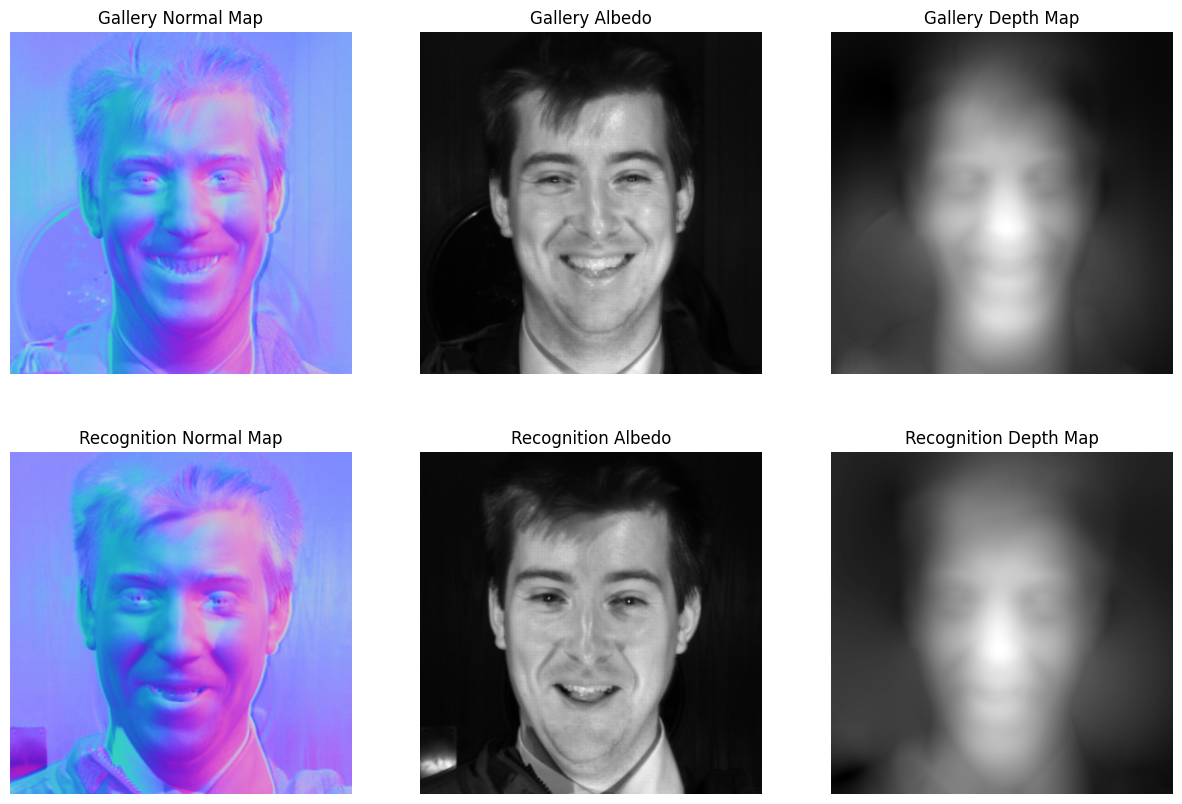

In [58]:
plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plt.imshow(gallery_normal)
plt.axis('off')
plt.title('Gallery Normal Map')

plt.subplot(2,3,2)
plt.imshow(gallery_albedo, cmap='gray')
plt.axis('off')
plt.title('Gallery Albedo')

plt.subplot(2,3,3)
plt.imshow(gallery_depthmap, cmap='gray')
plt.axis('off')
plt.title('Gallery Depth Map')

plt.subplot(2,3,4)
plt.imshow(recognition_normal)
plt.axis('off')
plt.title('Recognition Normal Map')

plt.subplot(2,3,5)
plt.imshow(recognition_albedo, cmap='gray')
plt.axis('off')
plt.title('Recognition Albedo')

plt.subplot(2,3,6)
plt.imshow(recognition_depthmap, cmap='gray')
plt.axis('off')
plt.title('Recognition Depth Map')

plt.show()

# Generate albedo, depthmap, normalmap

## Crop mặt

In [19]:
def adjust_box(box, shape):
    x, y, width, height = box
    center_x = x + width // 2
    center_y = y + height // 2

    im_size = int(height * 2)
    
    new_x = center_x - int(im_size//2)
    new_y = center_y - int(im_size//2)
    
    if new_x < 0:
        im_size = im_size - abs(new_x) * 2
        new_y = new_y + abs(new_x)
        new_x = 0
        
    if new_y < 0:
        im_size = im_size - abs(new_y) * 2
        new_x = new_x + abs(new_y)
        new_y = 0
    
    image_height, image_width = shape[:2]
    
    tmp_width = new_x + im_size - image_width
    if tmp_width > 0:
        im_size = im_size - tmp_width * 2
        new_y += tmp_width
        new_x += tmp_width
     
    tmp_height = new_y + im_size - image_height
    if tmp_height > 0:
        im_size = im_size - tmp_height * 2
        new_x += tmp_height
        new_y += tmp_height

    adjusted_box = [new_x, new_y, im_size, im_size]

    return adjusted_box


def crop_image(image, box, image_path):
    x, y, width, height = box

    face_crop = image[y:y + height, x:x + width]
    resized_face = cv2.resize(face_crop, (256, 256), interpolation=cv2.INTER_AREA)
    
    # Tạo tên file mới với hậu tố '_crop' trong cùng thư mục
    base, ext = os.path.splitext(image_path)
    new_image_path = f"{base}_crop{ext}"

    # Lưu ảnh đã cắt
    cv2.imwrite(new_image_path, resized_face.astype(np.float32))
 
        
def detect_face_in_all_exr(image_path):
    detector = MTCNN(device=f"CPU:0")
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    result = detector.detect_faces(image * 255)
    print(result)
    if len(result) == 1:
        if result[0]['confidence'] >= 0.9:
            box = adjust_box(result[0]['box'], image.shape)
            crop_image(image, box, image_path)
        else:
            print('Confidence < 0.9')
    elif len(result) >=2:
        # Tìm index của phần tử có confidence cao nhất (>= 0.99)
        max_confidence_index = max(
            (i for i, res in enumerate(result) if 'confidence' in res and res['confidence'] >= 0.9),
            key=lambda i: result[i]['confidence'],
            default=None
        )
        max_confidence_box = result[max_confidence_index]['box'] if max_confidence_index is not None else None
        
        if max_confidence_box:
            box = adjust_box(max_confidence_box, image.shape)
            crop_image(image, box, image_path)
        else:
            print('Confience 2 < 0.9')

In [ ]:
data_dir = './test_models/my_image/'

for filename in os.listdir(data_dir):
    detect_face_in_all_exr(os.path.join(data_dir, filename))

[{'box': [683, 1453, 422, 595], 'confidence': 0.994422972202301, 'keypoints': {'nose': [731, 1803], 'mouth_right': [875, 1912], 'right_eye': [871, 1666], 'left_eye': [728, 1705], 'mouth_left': [765, 1940]}}]
[{'box': [922, 1712, 495, 619], 'confidence': 0.9999125003814697, 'keypoints': {'nose': [1165, 2072], 'mouth_right': [1274, 2196], 'right_eye': [1285, 1950], 'left_eye': [1056, 1958], 'mouth_left': [1082, 2202]}}]
[{'box': [841, 1503, 719, 893], 'confidence': 0.9999896287918091, 'keypoints': {'nose': [1234, 2000], 'mouth_right': [1370, 2189], 'right_eye': [1388, 1842], 'left_eye': [1062, 1838], 'mouth_left': [1096, 2181]}}]


In [14]:
image_path = './test_models/my_image/media_20241227_214352_694008923852164597_crop.exr'

image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

min_val = np.min(image)
max_val = np.max(image)

min_val, max_val, image.shape

(0.0, 1.0, (1238, 1238, 3))